# Marketing Campaign Customer Clustering Analysis

## 1. Import Libraries and Load Data

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [51]:
# Load the data
df = pd.read_csv('clusteringcampaign.csv', sep='\t')
print(df.head())

# Check dataset information
print(f"Dataset shape: {df.shape}")
df.info()

# Adding new column 'Age'
df['Age'] = 2025 - df['Year_Birth']

     ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0

## 2. Data Preprocessing

In [52]:
# Check for missing values
print("\nMissing values:\n", df.isnull().sum())

# Handle missing values
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')
df['Income'].fillna(df['Income'].median(), inplace=True)

# Extract relevant features for clustering
# Selecting customer behavior and demographic features
features = [
    'Age', 'Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency',
    'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
    'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases',
    'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
    'NumWebVisitsMonth'
]

# Create a copy of the selected features
X = df[features].copy()

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\nStandardized data sample:\n", X_scaled_df.head())


Missing values:
 ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Age                     0
dtype: int64

Standardized data sample:
         Age  Year_Birth    Income   Kidhome  Teenhome   Recency  MntWines  \
0  0.985345   -0.985345  0.235696 -0.825218 -0.929894  0.307039  0.983781   
1  1.23

## 3. Model 1: K-Means Clustering

### 3.1 Elbow Method for K-Means


In [53]:
# Function to calculate Dunn Index
def dunn_index(X, labels):
    """
    Calculate Dunn Index for clustering validation

    Dunn Index = min(between_cluster_distance) / max(within_cluster_distance)
    Higher values indicate better clustering
    """
    # Calculate pairwise distances between all data points
    distances = squareform(pdist(X))

    # Get unique cluster labels
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels)

    if n_clusters <= 1:
        return 0

    # Calculate minimum inter-cluster distance
    min_between = float('inf')
    for i in range(n_clusters):
        for j in range(i+1, n_clusters):
            cluster_i_indices = np.where(labels == unique_labels[i])[0]
            cluster_j_indices = np.where(labels == unique_labels[j])[0]

            # Calculate distances between points in different clusters
            between_distances = distances[np.ix_(cluster_i_indices, cluster_j_indices)]
            min_between = min(min_between, np.min(between_distances))

    # Calculate maximum intra-cluster distance
    max_within = 0
    for i in range(n_clusters):
        cluster_indices = np.where(labels == unique_labels[i])[0]
        if len(cluster_indices) > 1:
            # Calculate distances between points in the same cluster
            within_distances = distances[np.ix_(cluster_indices, cluster_indices)]
            max_within = max(max_within, np.max(within_distances))

    # Avoid division by zero
    if max_within == 0:
        return float('inf')

    return min_between / max_within

# Calculate metrics for different values of k
k_range = range(2, 11)
inertia_values = []
silhouette_values = []
ch_values = []
db_values = []
dunn_values = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)

    # Calculate metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(silhouette_score(X_scaled, kmeans.labels_))
    ch_values.append(calinski_harabasz_score(X_scaled, kmeans.labels_))
    db_values.append(davies_bouldin_score(X_scaled, kmeans.labels_))
    dunn_values.append(dunn_index(X_scaled, kmeans.labels_))

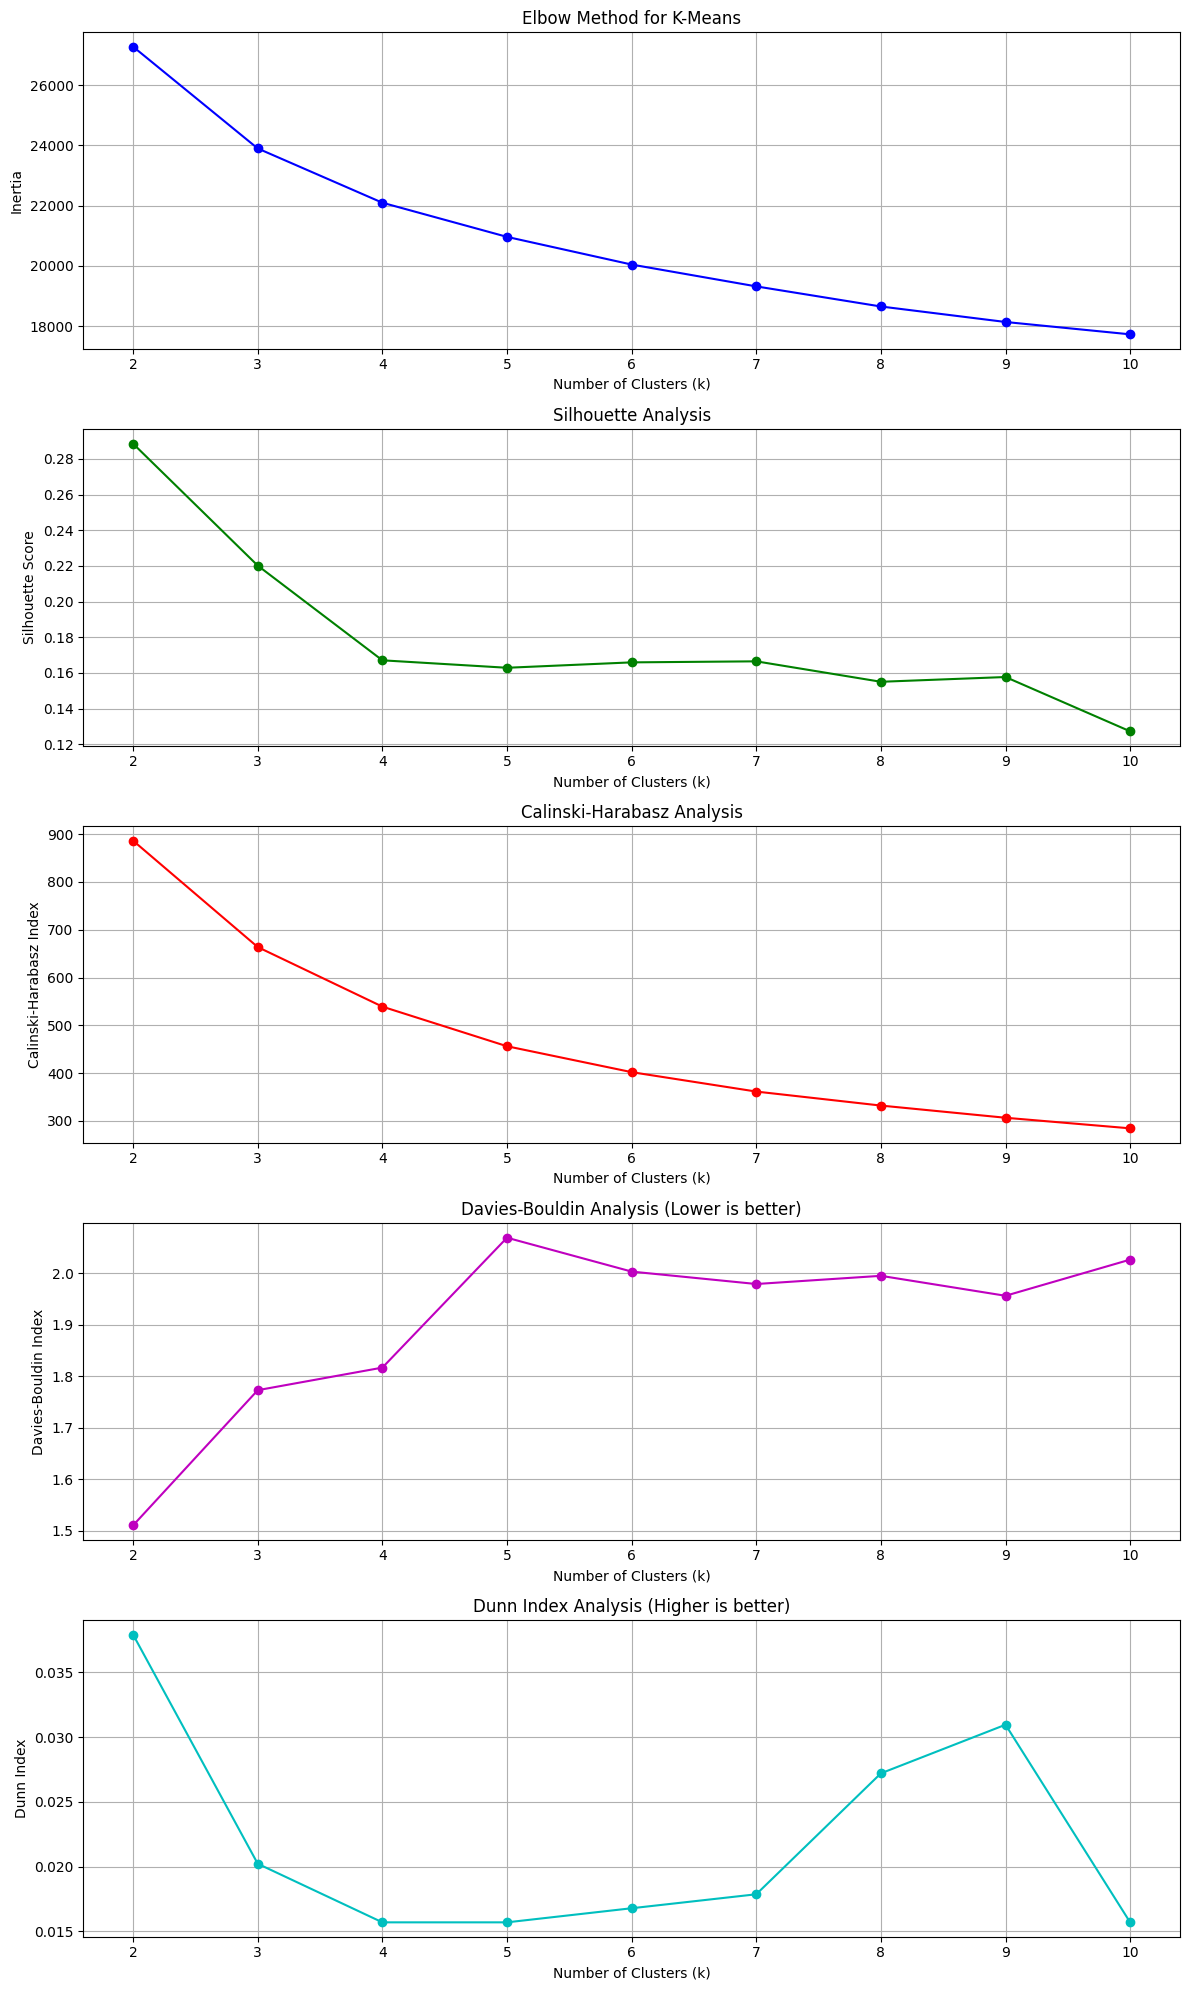

In [54]:
# Create a subplot with 5 rows and 1 column
fig, axes = plt.subplots(5, 1, figsize=(12, 20))

# Plot the Elbow Method
axes[0].plot(k_range, inertia_values, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for K-Means')
axes[0].grid(True)

# Plot the Silhouette Coefficient
axes[1].plot(k_range, silhouette_values, 'go-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')
axes[1].grid(True)

# Plot the Calinski-Harabasz Index
axes[2].plot(k_range, ch_values, 'ro-')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Calinski-Harabasz Index')
axes[2].set_title('Calinski-Harabasz Analysis')
axes[2].grid(True)

# Plot the Davies-Bouldin Index
axes[3].plot(k_range, db_values, 'mo-')
axes[3].set_xlabel('Number of Clusters (k)')
axes[3].set_ylabel('Davies-Bouldin Index')
axes[3].set_title('Davies-Bouldin Analysis (Lower is better)')
axes[3].grid(True)

# Plot the Dunn Index
axes[4].plot(k_range, dunn_values, 'co-')
axes[4].set_xlabel('Number of Clusters (k)')
axes[4].set_ylabel('Dunn Index')
axes[4].set_title('Dunn Index Analysis (Higher is better)')
axes[4].grid(True)

plt.tight_layout()

In [55]:
# Create a table to compare different metrics
metrics_df = pd.DataFrame({
    'Number of Clusters': list(k_range),
    'Inertia': inertia_values,
    'Silhouette Score': silhouette_values,
    'Calinski-Harabasz Index': ch_values,
    'Davies-Bouldin Index': db_values,
    'Dunn Index': dunn_values
})
print("\nComparison of clustering metrics:\n")
print(metrics_df)

# Determine optimal k based on the metrics
optimal_k = metrics_df.loc[metrics_df['Silhouette Score'].idxmax(), 'Number of Clusters']
print(f"\nBased on Silhouette Score, the optimal number of clusters is: {optimal_k}")


Comparison of clustering metrics:

   Number of Clusters       Inertia  Silhouette Score  \
0                   2  27277.666292          0.288546   
1                   3  23898.188844          0.220155   
2                   4  22096.452931          0.167033   
3                   5  20962.269085          0.162853   
4                   6  20042.966866          0.165882   
5                   7  19318.003180          0.166464   
6                   8  18650.394127          0.154994   
7                   9  18135.961613          0.157663   
8                  10  17725.584221          0.127189   

   Calinski-Harabasz Index  Davies-Bouldin Index  Dunn Index  
0               886.279001              1.510102    0.037904  
1               663.747194              1.772825    0.020226  
2               539.139492              1.816694    0.015705  
3               456.273703              2.069162    0.015705  
4               402.083507              2.003314    0.016793  
5              

### 3.2 Applying K-Means with the optimal k


K-Means Cluster Statistics:
                   Age    Income  Kidhome  Teenhome  Recency  MntWines  \
KMeans_Cluster                                                          
0               54.73  38690.66     0.71      0.55    48.70    101.16   
1               58.29  71603.88     0.06      0.44    49.69    593.80   

                MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
KMeans_Cluster                                                                  
0                    6.26            35.99             9.28              6.21   
1                   54.95           354.16            77.90             56.87   

                MntGoldProds  NumDealsPurchases  NumWebPurchases  \
KMeans_Cluster                                                     
0                      21.94               2.56             2.91   
1                      75.59               1.99             5.76   

                NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
KM

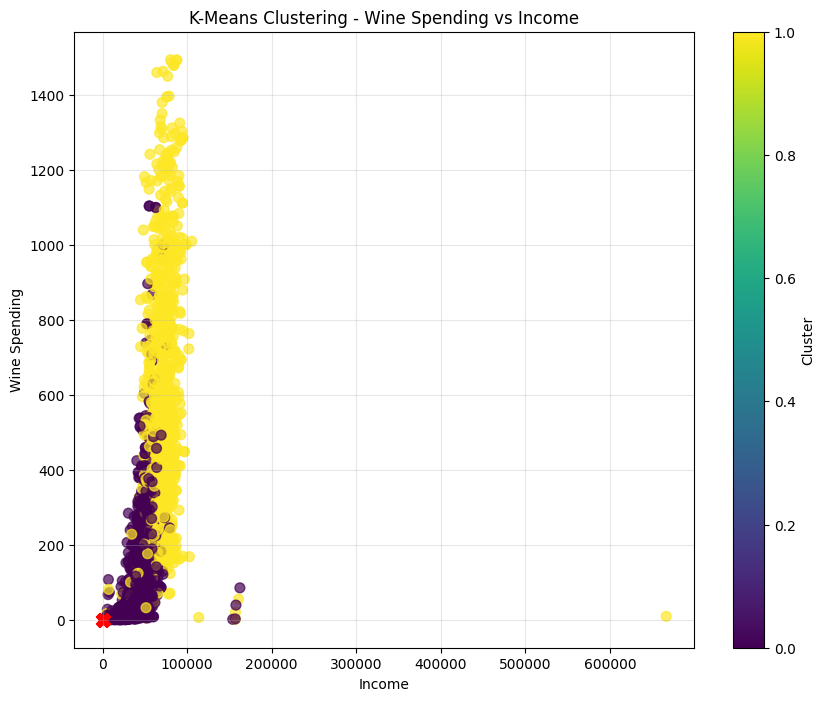

In [56]:
# Apply K-Means with the optimal number of clusters
optimal_kmeans = KMeans(n_clusters=int(optimal_k), random_state=42, n_init=10)
kmeans_labels = optimal_kmeans.fit_predict(X_scaled)

# Add cluster labels to the original dataframe
df['KMeans_Cluster'] = kmeans_labels

# Analyze clusters
kmeans_cluster_stats = df.groupby('KMeans_Cluster').agg({
    'Age': 'mean',
    'Income': 'mean',
    'Kidhome': 'mean',
    'Teenhome': 'mean',
    'Recency': 'mean',
    'MntWines': 'mean',
    'MntFruits': 'mean',
    'MntMeatProducts': 'mean',
    'MntFishProducts': 'mean',
    'MntSweetProducts': 'mean',
    'MntGoldProds': 'mean',
    'NumDealsPurchases': 'mean',
    'NumWebPurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean'
}).round(2)

print("\nK-Means Cluster Statistics:\n", kmeans_cluster_stats)

# Visualize the clusters - selecting two principal features
plt.figure(figsize=(10, 8))
plt.scatter(df['Income'], df['MntWines'], c=kmeans_labels, cmap='viridis', s=50, alpha=0.7)
plt.scatter(optimal_kmeans.cluster_centers_[:,1], optimal_kmeans.cluster_centers_[:,5],
            c='red', marker='X', s=100)
plt.title('K-Means Clustering - Wine Spending vs Income')
plt.xlabel('Income')
plt.ylabel('Wine Spending')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)

## 4. Model 2: Hierarchical Clustering (Agglomerative)

### 4.1 Dendrogram Analysis

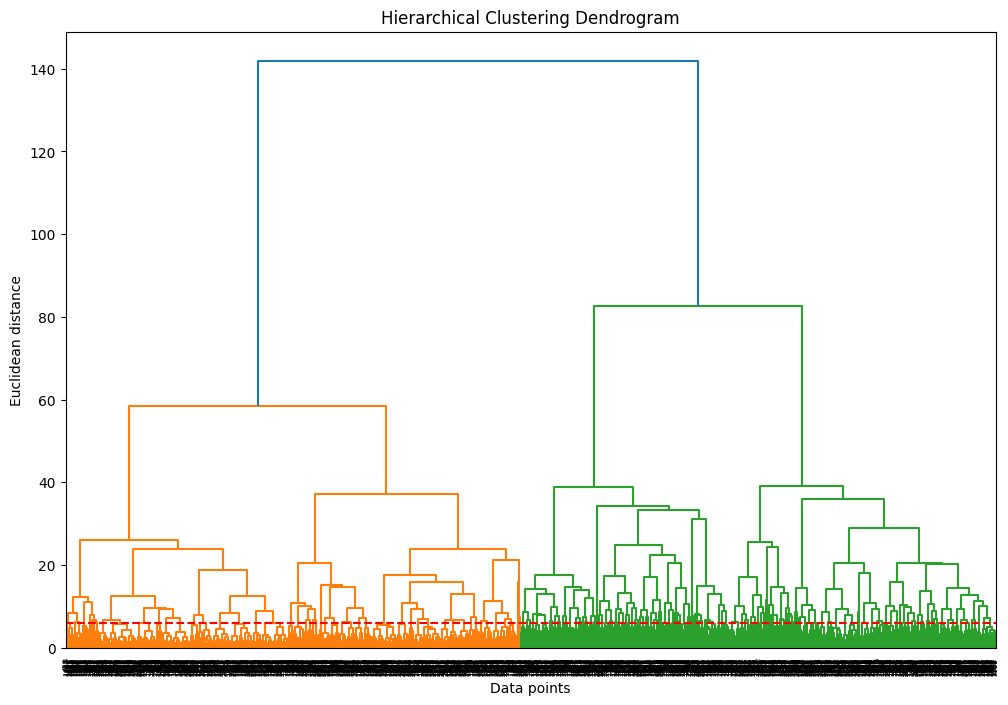

In [57]:
# Create dendrogram to help find the optimal number of clusters
plt.figure(figsize=(12, 8))
dendrogram_plot = dendrogram(linkage(X_scaled, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data points')
plt.ylabel('Euclidean distance')
plt.axhline(y=6, color='r', linestyle='--')

### 4.2 Evaluating Hierarchical Clustering with Different Numbers of Clusters

In [58]:
# Evaluate hierarchical clustering for different number of clusters
hc_silhouette_values = []
hc_ch_values = []
hc_db_values = []
hc_dunn_values = []

for k in k_range:
    hc = AgglomerativeClustering(n_clusters=k, linkage='ward')
    hc_labels = hc.fit_predict(X_scaled)

    # Calculate metrics
    hc_silhouette_values.append(silhouette_score(X_scaled, hc_labels))
    hc_ch_values.append(calinski_harabasz_score(X_scaled, hc_labels))
    hc_db_values.append(davies_bouldin_score(X_scaled, hc_labels))
    hc_dunn_values.append(dunn_index(X_scaled, hc_labels))

# Create a table to compare different metrics
hc_metrics_df = pd.DataFrame({
    'Number of Clusters': list(k_range),
    'Silhouette Score': hc_silhouette_values,
    'Calinski-Harabasz Index': hc_ch_values,
    'Davies-Bouldin Index': hc_db_values,
    'Dunn Index': hc_dunn_values
})
print("\nComparison of hierarchical clustering metrics:\n")
print(hc_metrics_df)

# Find optimal number of clusters for hierarchical clustering based on silhouette score
optimal_hc_k = hc_metrics_df.loc[hc_metrics_df['Silhouette Score'].idxmax(), 'Number of Clusters']
print(f"\nBased on Silhouette Score, the optimal number of clusters for hierarchical clustering is: {optimal_hc_k}")


Comparison of hierarchical clustering metrics:

   Number of Clusters  Silhouette Score  Calinski-Harabasz Index  \
0                   2          0.254816               803.589913   
1                   3          0.229015               612.740755   
2                   4          0.146594               494.164264   
3                   5          0.137877               402.670419   
4                   6          0.132263               348.991177   
5                   7          0.126922               312.715511   
6                   8          0.132571               286.967388   
7                   9          0.133712               266.924918   
8                  10          0.136411               251.289076   

   Davies-Bouldin Index  Dunn Index  
0              1.539887    0.034367  
1              1.928409    0.034367  
2              1.914661    0.030346  
3              2.365526    0.030346  
4              2.399151    0.030346  
5              2.320502    0.030346  
6   

### 4.3 Applying Hierarchical Clustering with the Optimal Number of Clusters


Hierarchical Clustering Statistics:
               Age    Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
HC_Cluster                                                                     
0           58.95  68030.76      0.1      0.56    48.64     544.1      46.21   
1           53.32  35782.96      0.8      0.45    49.60      53.7       5.56   

            MntMeatProducts  MntFishProducts  MntSweetProducts  MntGoldProds  \
HC_Cluster                                                                     
0                    300.39            65.80             47.78         69.04   
1                     27.91             8.06              5.48         17.96   

            NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
HC_Cluster                                                            
0                        2.43             5.75                 4.61   
1                        2.21             2.35                 0.63   

            NumStorePurchases  NumW

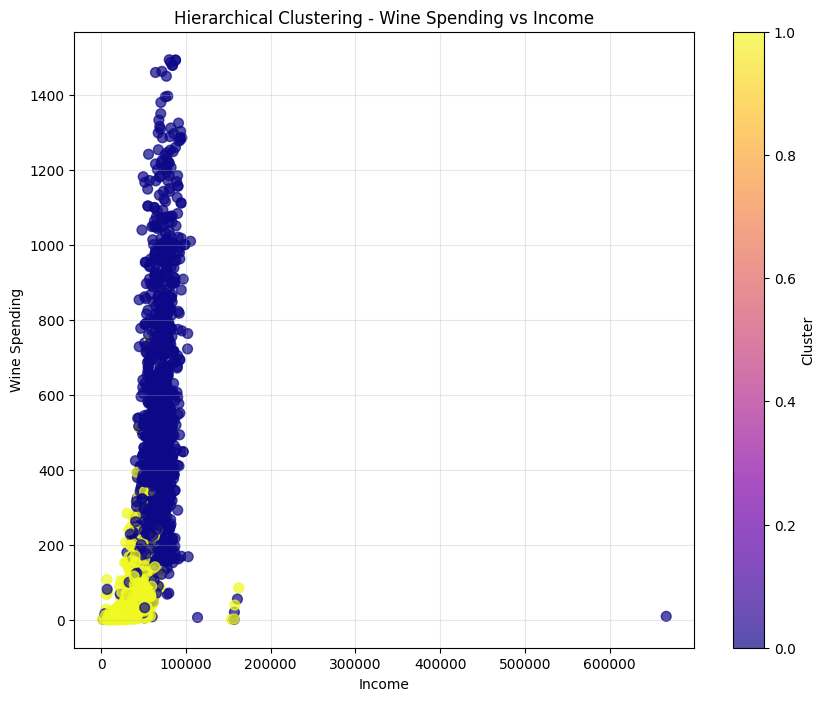

In [59]:
# Apply hierarchical clustering with the optimal number of clusters
optimal_hc = AgglomerativeClustering(n_clusters=int(optimal_hc_k), linkage='ward')
hc_labels = optimal_hc.fit_predict(X_scaled)

# Add hierarchical clustering labels to the original dataframe
df['HC_Cluster'] = hc_labels

# Analyze clusters
hc_cluster_stats = df.groupby('HC_Cluster').agg({
    'Age': 'mean',
    'Income': 'mean',
    'Kidhome': 'mean',
    'Teenhome': 'mean',
    'Recency': 'mean',
    'MntWines': 'mean',
    'MntFruits': 'mean',
    'MntMeatProducts': 'mean',
    'MntFishProducts': 'mean',
    'MntSweetProducts': 'mean',
    'MntGoldProds': 'mean',
    'NumDealsPurchases': 'mean',
    'NumWebPurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean'
}).round(2)

print("\nHierarchical Clustering Statistics:\n", hc_cluster_stats)

# Visualize the clusters - selecting two principal features
plt.figure(figsize=(10, 8))
plt.scatter(df['Income'], df['MntWines'], c=hc_labels, cmap='plasma', s=50, alpha=0.7)
plt.title('Hierarchical Clustering - Wine Spending vs Income')
plt.xlabel('Income')
plt.ylabel('Wine Spending')
plt.colorbar(label='Cluster')
plt.grid(True, alpha=0.3)

## 5. Comparison of Clustering Methods and Metrics

### 5.1 Explanation of Clustering Quality Metrics

Mathematical Explanation of Clustering Metrics:

1. Inertia (Sum of Squared Distances):
   - Mathematical equation: $$ Inertia = \sum min(||x_i - c_j||²) $$where $x_i$ is a data point and $c_j$ is the centroid of the nearest cluster
   - Measures the compactness of clusters by calculating the sum of squared distances between each sample and its assigned cluster center
   - Lower values indicate more compact clusters
   - Limitation: Decreases as the number of clusters increases, making it difficult to determine the optimal number of clusters (needs to be used with the Elbow Method)

2. Silhouette Coefficient:
   - Mathematical equation: $$s(i) = \frac{(b(i) - a(i))}{ max(a(i), b(i)}$$ where $a(i)$ is the mean distance between point $i$ and other points in the same cluster, and $b(i)$ is the mean distance to points in the nearest neighboring cluster
   - Measures how similar an object is to its own cluster compared to other clusters
   - Range: $[-1, 1]$ where:
     * Values near 1 indicate the sample is far from neighboring clusters (well-clustered)
     * Values near 0 indicate the sample is close to the decision boundary between clusters
     * Values near -1 indicate the sample might be assigned to the wrong cluster
   - Advantage: Can be used to determine the optimal number of clusters without ground truth labels

3. Calinski-Harabasz Index (Variance Ratio Criterion):
   - Mathematical equation: $$CH = \frac{[tr(B_k) / (k-1)] }{ [tr(W_k) / (n-k)]}$$ where $B_k$ is the between-cluster dispersion matrix, $W_k$ is the within-cluster dispersion matrix, $k$ is the number of clusters, and n is the number of observations
   - Measures the ratio of between-cluster variance to within-cluster variance
   - Higher values indicate better defined clusters
   - Advantage: Takes into account cluster size and separation

4. Davies-Bouldin Index:
   - Mathematical equation: $$DB = \frac{1}{k} \sum max(R_{ij})$$ where $i \neq j$ and $R_{ij} = \frac{(s_i + s_j) }{ d_{ij}}$
    - $s_i$ is the average distance of points in cluster $i$ to its centroid,
    - $d_{ij}$ is the distance between centroids of clusters $i$ and $j$
   - Measures the average similarity between each cluster and its most similar cluster
   - Lower values indicate better clustering (more distinct clusters)
   - Advantage: Considers both the scatter within the clusters and the separation between clusters

5. Dunn Index:
   - Mathematical equation: DI = $$\frac{min(δ(C_i, C_j)) }{ max(Δ(C_k))}$$ where $δ(C_i, C_j)$ is the inter-cluster distance between clusters C_i and $C_j$, and $Δ(C_k)$ is the intra-cluster diameter of cluster $C_k$
   - Measures the ratio of the smallest inter-cluster distance to the largest intra-cluster distance
   - Higher values indicate better clustering (compact and well-separated clusters)
   - Advantage: Directly identifies compact and well-separated clusters

### 5.2 Comparison of K-Means and Hierarchical Clustering Results

In [60]:
# Compare the clustering methods
print("\nComparison of Clustering Methods:\n")
print(f"K-Means (k={int(optimal_k)}):")
print(f"Silhouette Score: {silhouette_values[int(optimal_k)-2]:.4f}")
print(f"Calinski-Harabasz Index: {ch_values[int(optimal_k)-2]:.4f}")
print(f"Davies-Bouldin Index: {db_values[int(optimal_k)-2]:.4f}")
print(f"Dunn Index: {dunn_values[int(optimal_k)-2]:.4f}")

print(f"\nHierarchical Clustering (k={int(optimal_hc_k)}):")
print(f"Silhouette Score: {hc_silhouette_values[int(optimal_hc_k)-2]:.4f}")
print(f"Calinski-Harabasz Index: {hc_ch_values[int(optimal_hc_k)-2]:.4f}")
print(f"Davies-Bouldin Index: {hc_db_values[int(optimal_hc_k)-2]:.4f}")
print(f"Dunn Index: {hc_dunn_values[int(optimal_hc_k)-2]:.4f}")

# Calculate the agreement between the two clustering methods using adjusted Rand index
from sklearn.metrics import adjusted_rand_score

if int(optimal_k) == int(optimal_hc_k):
    ari_score = adjusted_rand_score(kmeans_labels, hc_labels)
    print(f"\nAdjusted Rand Index (clustering agreement): {ari_score:.4f}")
else:
    print("\nThe optimal number of clusters differs between methods, so direct comparison is not applicable.")


Comparison of Clustering Methods:

K-Means (k=2):
Silhouette Score: 0.2885
Calinski-Harabasz Index: 886.2790
Davies-Bouldin Index: 1.5101
Dunn Index: 0.0379

Hierarchical Clustering (k=2):
Silhouette Score: 0.2548
Calinski-Harabasz Index: 803.5899
Davies-Bouldin Index: 1.5399
Dunn Index: 0.0344

Adjusted Rand Index (clustering agreement): 0.6327


K-Means memberikan hasil clustering yang sedikit lebih baik dibandingkan Hierarchical Clustering untuk dataset ini berdasarkan semua metrik evaluasi. Meskipun demikian, kedua metode menghasilkan struktur cluster yang cukup serupa (ditunjukkan oleh Adjusted Rand Index 0.6327).

### 5.3 Recommended Clustering Solution and Insights

In [61]:
# Find the better clustering method based on metrics
kmeans_avg_score = (silhouette_values[int(optimal_k)-2] - db_values[int(optimal_k)-2] +
                    ch_values[int(optimal_k)-2]/1000 + dunn_values[int(optimal_k)-2])

hc_avg_score = (hc_silhouette_values[int(optimal_hc_k)-2] - hc_db_values[int(optimal_hc_k)-2] +
                hc_ch_values[int(optimal_hc_k)-2]/1000 + hc_dunn_values[int(optimal_hc_k)-2])

print("\nNormalized combined metric scores:")
print(f"K-Means: {kmeans_avg_score:.4f}")
print(f"Hierarchical: {hc_avg_score:.4f}")

if kmeans_avg_score > hc_avg_score:
    recommended_method = "K-Means"
    best_clusters = optimal_k
    best_labels = kmeans_labels
else:
    recommended_method = "Hierarchical Clustering"
    best_clusters = optimal_hc_k
    best_labels = hc_labels

print(f"\nRecommended clustering solution: {recommended_method} with {int(best_clusters)} clusters")


Normalized combined metric scores:
K-Means: -0.2974
Hierarchical: -0.4471

Recommended clustering solution: K-Means with 2 clusters


Metrik kombinasi ini menggabungkan semua skor evaluasi sebelumnya (Silhouette, Calinski-Harabasz, Davies-Bouldin, dan Dunn Index) ke dalam satu nilai yang dinormalisasi untuk memudahkan perbandingan.
Nilai yang lebih tinggi (atau mendekati 0 jika negatif) menunjukkan performa clustering yang lebih baik. K-Means memiliki nilai -0.2974 yang lebih baik dibandingkan Hierarchical Clustering dengan nilai -0.4471.

## 6. Final Customer Segments Analysis and Recommendations


Final Customer Segment Profiles:
                Income    Age  Kidhome  Teenhome  Recency  MntWines  \
Best_Cluster                                                          
0             38690.66  54.73     0.71      0.55    48.70    101.16   
1             71603.88  58.29     0.06      0.44    49.69    593.80   

              MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  \
Best_Cluster                                                                  
0                  6.26            35.99             9.28              6.21   
1                 54.95           354.16            77.90             56.87   

              MntGoldProds  NumDealsPurchases  NumWebPurchases  \
Best_Cluster                                                     
0                    21.94               2.56             2.91   
1                    75.59               1.99             5.76   

              NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
Best_Cluster            

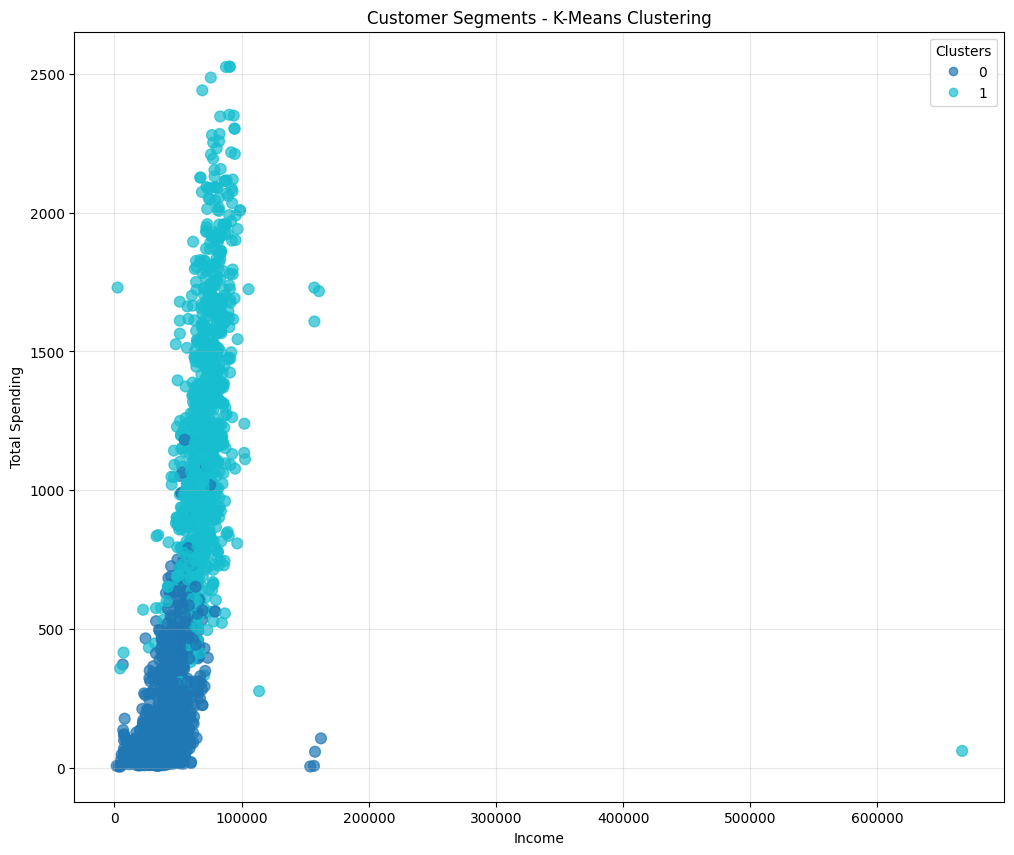

In [62]:
# Select the best clustering solution
df['Best_Cluster'] = best_labels

# Create detailed profile for each cluster
cluster_profiles = df.groupby('Best_Cluster').agg({
    'Income': 'mean',
    'Age': 'mean',
    'Kidhome': 'mean',
    'Teenhome': 'mean',
    'Recency': 'mean',
    'MntWines': 'mean',
    'MntFruits': 'mean',
    'MntMeatProducts': 'mean',
    'MntFishProducts': 'mean',
    'MntSweetProducts': 'mean',
    'MntGoldProds': 'mean',
    'NumDealsPurchases': 'mean',
    'NumWebPurchases': 'mean',
    'NumCatalogPurchases': 'mean',
    'NumStorePurchases': 'mean',
    'NumWebVisitsMonth': 'mean',
    'Response': 'mean',
    'ID': 'count'  # Count number of customers in each cluster
}).round(2)

# Rename count column for clarity
cluster_profiles = cluster_profiles.rename(columns={'ID': 'ClusterSize'})

print("\nFinal Customer Segment Profiles:")
print(cluster_profiles)

# Calculate total spending per cluster
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts',
                 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
cluster_profiles['TotalSpending'] = cluster_profiles[spending_cols].sum(axis=1)

# Calculate relative spending pattern
for col in spending_cols:
    cluster_profiles[f'{col}_Pct'] = (cluster_profiles[col] / cluster_profiles['TotalSpending'] * 100).round(1)

print("\nCluster Spending Patterns (% of total spending):")
print(cluster_profiles[[col + '_Pct' for col in spending_cols]])

# Visualize the final clusters in 2D - using spending and income
plt.figure(figsize=(12, 10))
scatter = plt.scatter(df['Income'], df['TotalSpending'] if 'TotalSpending' in df.columns
                     else df[spending_cols].sum(axis=1),
                     c=df['Best_Cluster'], cmap='tab10', s=60, alpha=0.7)
plt.title(f'Customer Segments - {recommended_method} Clustering')
plt.xlabel('Income')
plt.ylabel('Total Spending')
plt.grid(True, alpha=0.3)
plt.legend(*scatter.legend_elements(), title="Clusters")

In [63]:
# Final insights and marketing recommendations for each cluster
print("\nFinal Customer Segment Insights and Marketing Recommendations:")
for i in range(int(best_clusters)):
    profile = cluster_profiles.loc[i]
    print(f"\nCluster {i} - {profile['ClusterSize']} customers:")

    # Demographics
    print(f"• Demographics: Average age {profile['Age']:.1f}, Income ${profile['Income']:,.2f}")
    print(f"• Household: {profile['Kidhome']:.1f} kids, {profile['Teenhome']:.1f} teens")

    # Spending pattern
    print(f"• Total spending: ${profile['TotalSpending']:.2f}")

    # Top spending categories
    spending_pcts = [profile[f'{col}_Pct'] for col in spending_cols]
    top_category = spending_cols[spending_pcts.index(max(spending_pcts))].replace('Mnt', '')
    print(f"• Top spending category: {top_category} ({max(spending_pcts):.1f}% of budget)")

    # Channel preference
    channels = ['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
    channel_values = [profile[ch] for ch in channels]
    preferred_channel = channels[channel_values.index(max(channel_values))].replace('Num', '')
    print(f"• Preferred shopping channel: {preferred_channel} ({max(channel_values):.1f} purchases)")

    # Campaign response
    print(f"• Campaign response rate: {profile['Response']*100:.1f}%")

    # Days since last purchase
    print(f"• Recency (days since last purchase): {profile['Recency']:.1f} days")


Final Customer Segment Insights and Marketing Recommendations:

Cluster 0 - 1318.0 customers:
• Demographics: Average age 54.7, Income $38,690.66
• Household: 0.7 kids, 0.6 teens
• Total spending: $180.84
• Top spending category: Wines (55.9% of budget)
• Preferred shopping channel: StorePurchases (3.9 purchases)
• Campaign response rate: 10.0%
• Recency (days since last purchase): 48.7 days

Cluster 1 - 922.0 customers:
• Demographics: Average age 58.3, Income $71,603.88
• Household: 0.1 kids, 0.4 teens
• Total spending: $1213.27
• Top spending category: Wines (48.9% of budget)
• Preferred shopping channel: StorePurchases (8.5 purchases)
• Campaign response rate: 22.0%
• Recency (days since last purchase): 49.7 days


Kesimpulan:
1. Cluster 1 mewakili pelanggan dengan nilai tinggi (high-value) dengan pengeluaran jauh lebih besar meskipun jumlahnya lebih sedikit.
2. Kedua kelompok menyukai kategori Wine, tetapi Cluster 1 membelanjakan jumlah yang jauh lebih besar.
3. Cluster 1 memiliki pendapatan lebih tinggi, rumah tangga lebih kecil, dan menunjukkan respons yang lebih baik terhadap kampanye pemasaran.
4. Frekuensi belanja Cluster 1 lebih dari dua kali lipat dibandingkan Cluster 0
Recency (waktu sejak pembelian terakhir) relatif sama untuk kedua cluster.

Informasi ini dapat digunakan untuk merancang strategi pemasaran yang ditargetkan untuk masing-masing segmen pelanggan.